### Generation of showers with CaloGAN 

Check that `keras` has already been installed. If not do :

$ `conda install -c anaconda keras`

In [1]:
latent_size = 1024

In [2]:
import keras
from keras.layers import Input, Lambda, Activation, AveragePooling2D, UpSampling2D
from keras.models import Model
from keras.layers.merge import multiply
import keras.backend as K

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib import ticker, cm
from matplotlib.colors import LogNorm

Using TensorFlow backend.


In [3]:
%cd /home/eren/CaloGAN/models/
from architectures import build_generator, build_discriminator, sparse_softmax
from ops import scale, inpainting_attention
%cd -

/home/eren/CaloGAN/models
/home/eren/CaloGAN/analysis


In [4]:
# input placeholders
latent = Input(shape=(latent_size, ), name='z') # noise
input_energy = Input(shape=(1, ), dtype='float32') # requested energy of the particle shower
generator_inputs = [latent, input_energy]

# multiply the (scaled) energy into the latent space
h = Lambda(lambda x: x[0] * x[1])([latent, scale(input_energy, 100)])

# build 5 LAGAN-style generators (checkout out `build_generator` in architectures.py)
img_layer = []
for i in range(5):
    img_layer.append(build_generator(h, 12, 12))
        
# inpainting
zero2one = AveragePooling2D(pool_size=(1, 1))(UpSampling2D(size=(1, 1))(img_layer[0]))
img_layer[1] = inpainting_attention(img_layer[1], zero2one)
for j in range(1,4):
    one2N = AveragePooling2D(pool_size=(1, 1))(img_layer[j])
    img_layer[j+1] = inpainting_attention(img_layer[j+1], one2N)

generator_outputs = []

## outputs
for k in range(5):
    generator_outputs.append(Activation('relu')(img_layer[k]))
        



Instructions for updating:
Colocations handled automatically by placer.


In [5]:
# build the actual model
generator = Model(generator_inputs, generator_outputs)
# load trained weights
generator.load_weights('/home/eren/CaloGAN/data/params_generator-Eph150-5lay-v2-Hyp_Bs256_L005_nomLR150.hdf5')
# 30,000 is the number of showers we want to generate right now
noise = np.random.normal(0, 1, (50000, latent_size))
sampled_energy = np.random.uniform(50, 50, (50000, 1))

#sampled_energy25 = np.random.uniform(25, 25, (30000, 1))
#sampled_energy75 = np.random.uniform(75, 75, (30000, 1))

images = generator.predict([noise, sampled_energy], verbose=True)
#images25 = generator.predict([noise, sampled_energy25], verbose=True)
#images75 = generator.predict([noise, sampled_energy75], verbose=True)


50000/50000 [==============================] - 96s 2ms/step


In [6]:
# we need to multiply images by 1000 to match order of magnitude of generated images to real images
## watch out for python3 changes: map method doesnt return list!
images = list(map(lambda x: np.squeeze(x * 1000), images))
#images25 = list(map(lambda x: np.squeeze(x * 1000), images25))
#images75 = list(map(lambda x: np.squeeze(x * 1000), images75))

In [7]:
gen_images_gamma = [
   images[k] for k in range(5)
]

In [8]:
images[0].shape

(50000, 12, 12)

In [9]:
import h5py
g = h5py.File('/home/eren/CaloGAN/data/gamma50GeV.hdf5', 'r')

## Loading Geant4 images
gamma = []
for j in range(5): 
    gamma.append(g['layer_{}'.format(j)][:50000])


vmin = [ gamma[k].mean(axis=0).min() for k in range(5)]
vmax = [ gamma[k].mean(axis=0).max() for k in range(5) ]

sizes = [gamma[0].shape[1], gamma[0].shape[2]] * 5


In [ ]:
gamma[0].shape
#e = g['energy'][:]


In [10]:
real_images_gamma = [gamma[k] for k in range(5)]

In [11]:
plt.rcParams.update({'font.size': 20})

In [12]:
def plot_image(image, layer=1, vmin=None, vmax=None):
    '''
    Args:
    -----
        image: ndarray with energies collected by each calo cell
        layer: int in {0,1,2}, useful to resize image correctly
        vmin: float, min energy to clip at
        vmax: float, max energy to clip at
    '''
    fig = plt.figure(figsize=(20,20))
    im = plt.imshow(image,
               aspect=float(sizes[layer*2 + 1])/sizes[layer*2],
               interpolation='nearest',
               norm=LogNorm(vmin, vmax)
    )
    cbar = plt.colorbar(fraction=0.0455)
    cbar.set_label(r'Energy (MeV)', y=0.83)
    cbar.ax.tick_params()
   
    xticks = range(sizes[layer*2 + 1])
    yticks = range(sizes[layer*2])

    plt.xticks(xticks)
    plt.yticks(yticks)
    plt.xlabel(r'$x$ Cell ID')
    plt.ylabel(r'$z$ Cell ID')

    plt.tight_layout()
    return im
    
    

In [ ]:
plot_image(real_images_gamma[0][234])

In [ ]:
for i in range(5):
    plot_image(np.squeeze(real_images_gamma[i][:]).mean(axis=0), 
               layer=i) 
              # vmin=vmin[i], vmax=vmax[i])
    #plt.savefig('gamma_{}_geant.pdf'.format(i), transparent=True)


In [ ]:
for i in range(5):
    plot_image(np.squeeze(gen_images_gamma[i]).mean(axis=0),
               layer=i,
               vmin=vmin[i], vmax=vmax[i]
    )
    #plt.savefig('calogan-images/500Epoch/gamma_GAN_{}.pdf'.format(i), transparent=True)

In [13]:
def plot_nn(layer, gen_images=gen_images_gamma, real_images=real_images_gamma, vmin=vmin, vmax=vmax, sizes=sizes, nparticles=5):
    '''
    vmin and vmax are the arrays defined above based on GEANT image ranges
    sizes is also defined above
    npartciles: (default=5), number of random showers to plot
    '''
    from sklearn.neighbors import NearestNeighbors
    nn = NearestNeighbors(1, metric='euclidean')
    nn.fit(gen_images[layer].reshape(gen_images[layer].shape[0], -1))
    f, axarr = plt.subplots(2, nparticles, figsize=(25, 10))
    particles = np.random.randint(low=0, high=real_images[layer].shape[0], size=nparticles)

    for i, sel in enumerate(particles):
        nbr = int(nn.kneighbors(real_images[layer][sel].ravel().reshape(1, -1))[-1])
        def _plot_im(n_row, images):
            im = axarr[n_row, i].imshow(images,
                                        interpolation='nearest',
                                        norm=LogNorm(vmin=vmin[layer], vmax=vmax[layer]),
                                        aspect=sizes[1+(layer*2)] / float(sizes[(0)+(layer*2)]),
                                       )
            axarr[n_row, i].tick_params(axis='both', which='both', bottom='off', top='off',
                                    left='off', right='off', labelbottom='off',
                                    labelleft='off')
            return im

        cnv = [_plot_im(*content) for content in enumerate([real_images[layer][sel], gen_images[layer][nbr]])]
    axarr[0][0].set_ylabel('GEANT')
    axarr[1][0].set_ylabel('GAN')
    cax = f.add_axes([0.93, 0.11, 0.03, 0.8])
    cb = f.colorbar(cnv[0], cax=cax)
    cb.set_label(r'Energy (MeV)', y=0.73)
    #plt.savefig('/home/eren/CaloGAN/analysis/nn{}.pdf'.format(layer), pad_inches=2, transparent=True, bbox_inches='tight')

/software/anaconda3/5.2/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


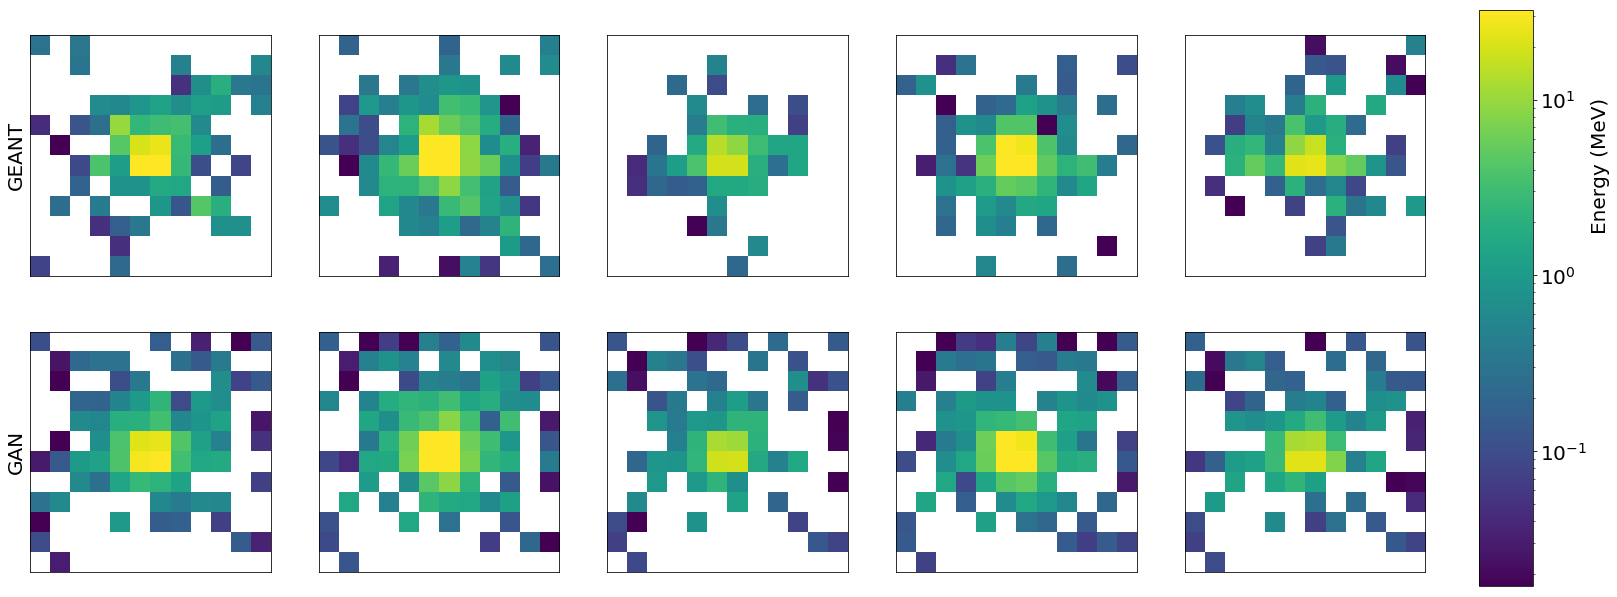

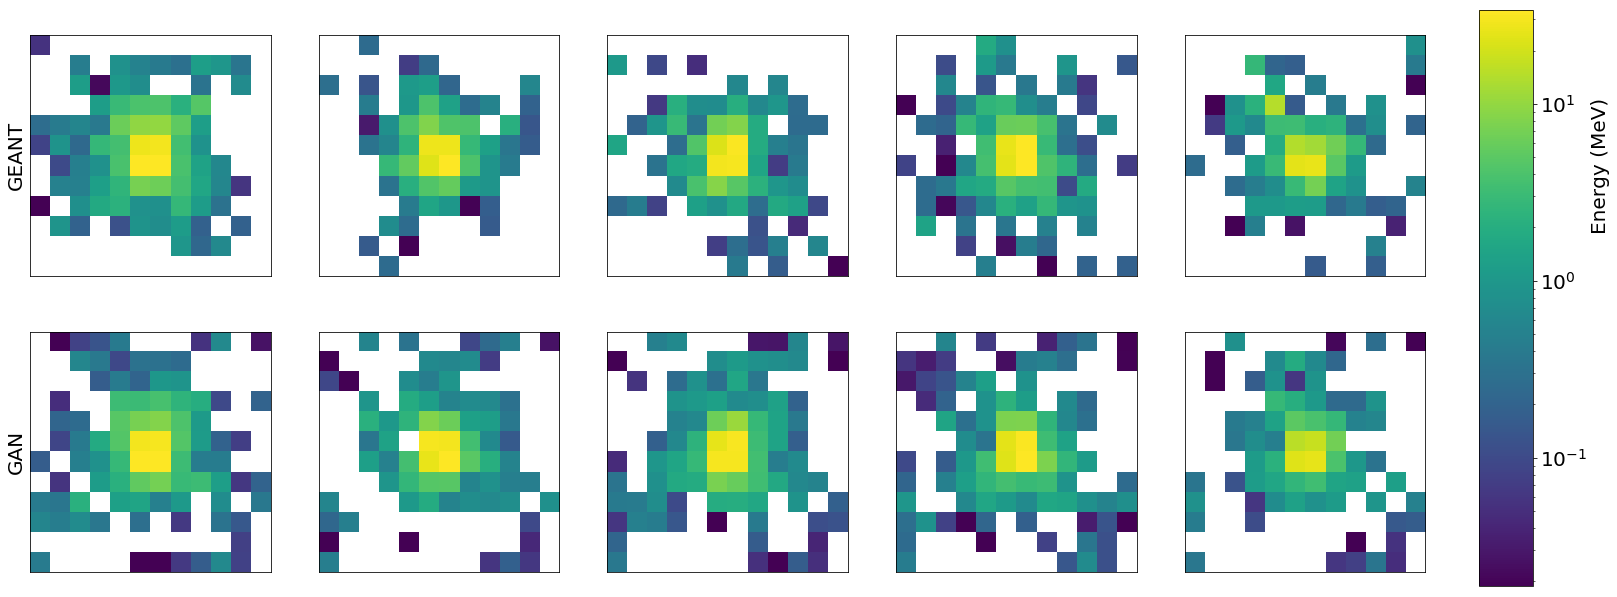

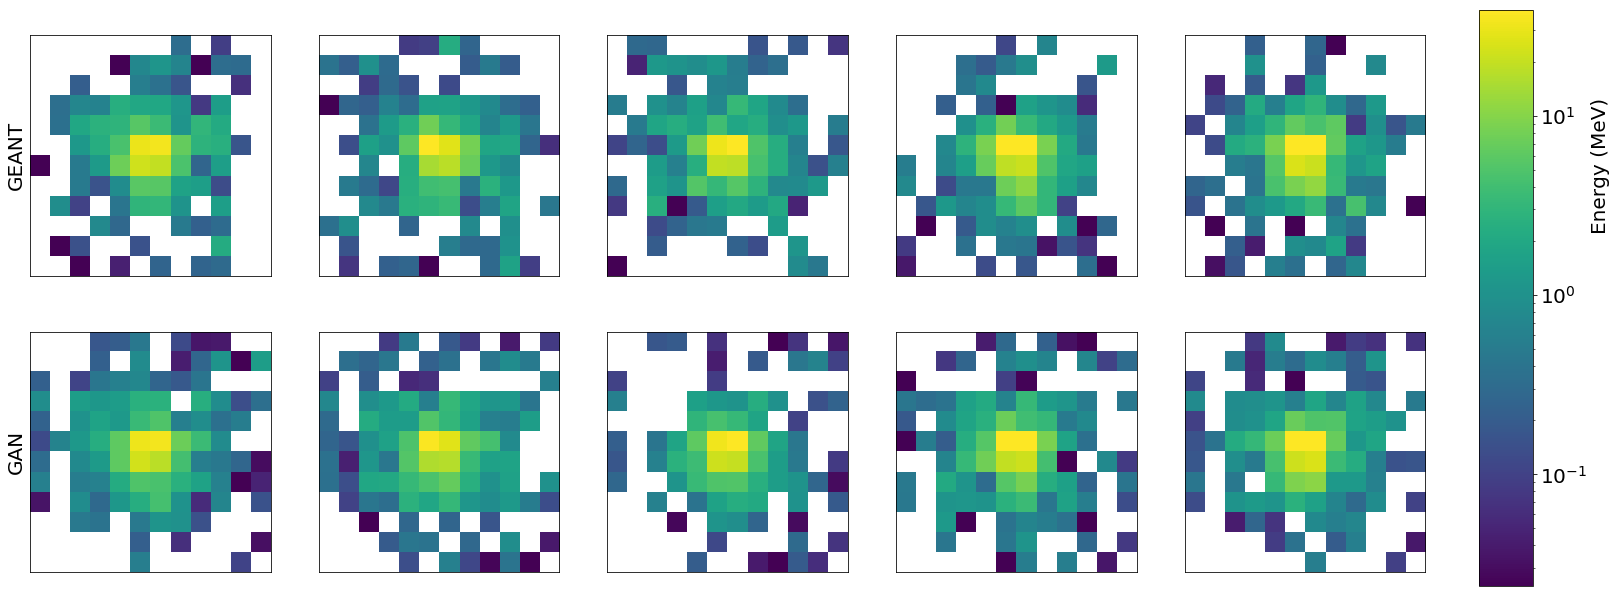

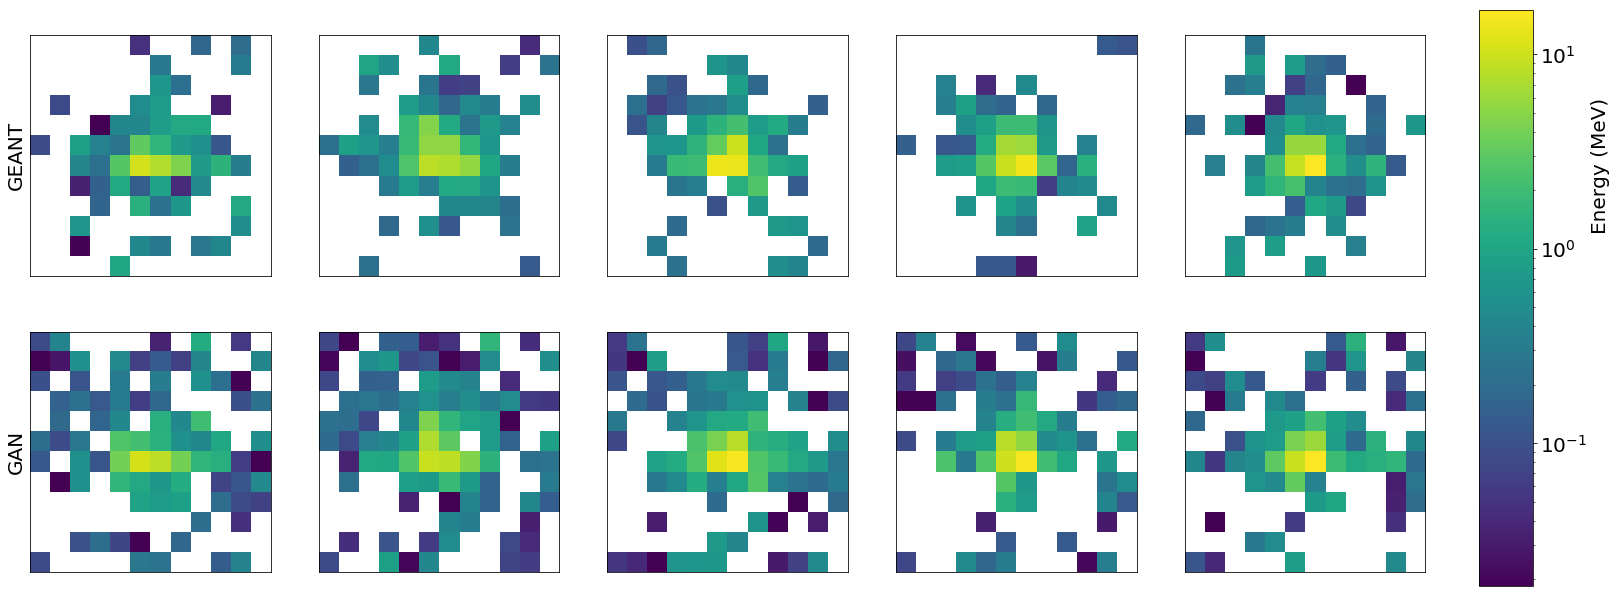

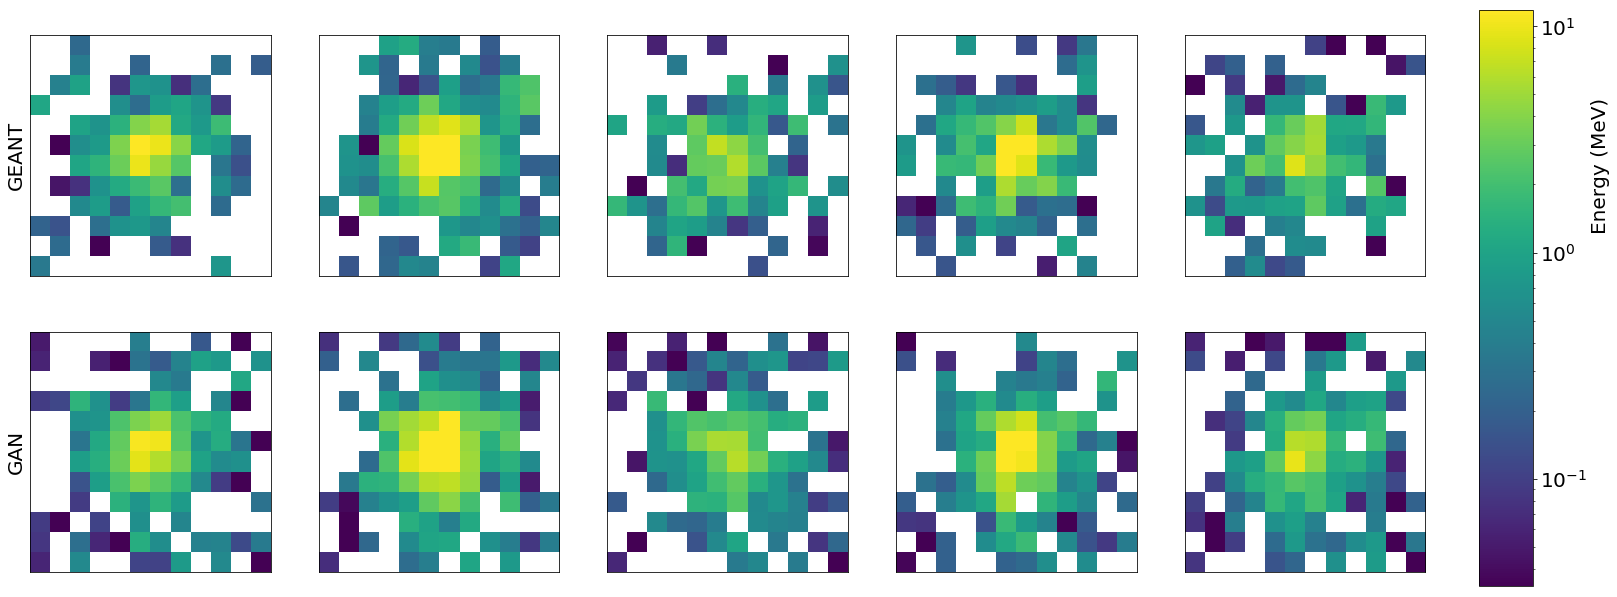

In [14]:
for i in range(0,5):
    plot_nn(layer=i)

### Total Energy distributions

In [15]:
dgen_gamma = {
    'layer_0': np.squeeze(images[0]),
    'layer_1': np.squeeze(images[1]),
    'layer_2': np.squeeze(images[2]),
    'layer_3': np.squeeze(images[3]),
    'layer_4': np.squeeze(images[4])
}

In [16]:
from feats1d import *
plt.rcParams.update({'font.size': 20})
colors = plt.cm.gnuplot2(np.linspace(0.2, 0.8, 3))

In [ ]:
dgen_gamma25 = {
    'layer_0': np.squeeze(images25[0]),
    'layer_1': np.squeeze(images25[1]),
    'layer_2': np.squeeze(images25[2]),
    'layer_3': np.squeeze(images25[3]),
    'layer_4': np.squeeze(images25[4])
}

In [ ]:
dgen_gamma75 = {
    'layer_0': np.squeeze(images75[0]),
    'layer_1': np.squeeze(images75[1]),
    'layer_2': np.squeeze(images75[2]),
    'layer_3': np.squeeze(images75[3]),
    'layer_4': np.squeeze(images75[4])
}

In [17]:
etot_gen_gamma = total_energy(dgen_gamma)
etot_orig_gamma = total_energy(g)
#etot_gen_gamma25 = total_energy(dgen_gamma25)
#etot_gen_gamma75 = total_energy(dgen_gamma75)

In [ ]:
etot_gen_gamma

/software/anaconda3/5.2/lib/python3.6/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


Text(0.5, 0, '$\\hat{E}_\\mathrm{tot}$ (MeV)')

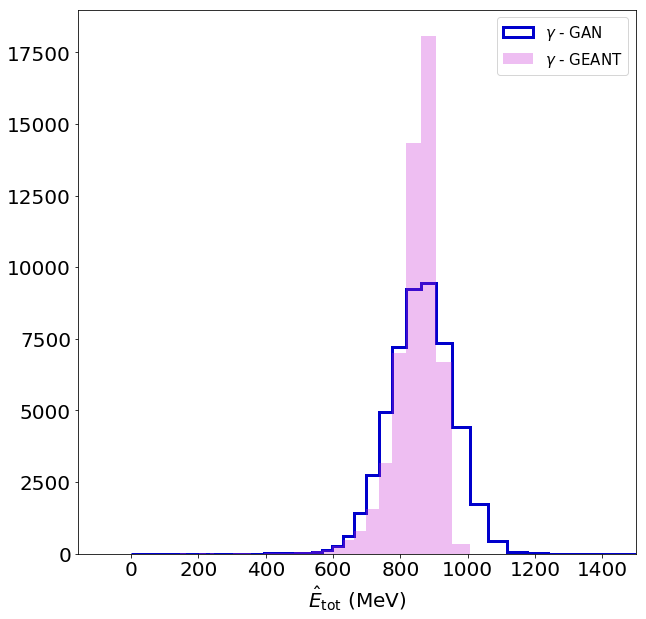

In [18]:
#bins = np.linspace(0, 1500, 200)
bins = np.logspace(-1, 3.5, 200)
plt.figure(figsize=(10, 10))
_ = plt.hist(etot_gen_gamma, bins=bins, histtype='step', linewidth=3,
             alpha=1, color=colors[0],
             label=r'$\gamma$ - GAN')

_ = plt.hist(etot_orig_gamma, bins=bins, histtype='stepfilled', linewidth=3,
             alpha=0.3, color=colors[1],
             label=r'$\gamma$ - GEANT')
#_ = plt.hist(etot_gen_gamma75, bins=bins, histtype='step', linewidth=3,
#             alpha=1, color=colors[2],
#             label=r'$\gamma$ 75 GeV - GAN')

#_ = plt.hist(etot_gen_gamma25, bins=bins, histtype='step', linewidth=3,
#             alpha=1, color=colors[1],
#             label=r'$\gamma$ 25 GeV - GAN')

plt.legend(loc='upper right', fontsize=15, ncol=1)
#plt.yscale('log')
#plt.xscale('log')
plt.xlim(xmax=1500)
plt.xlabel(r'$\hat{E}_\mathrm{tot}$ (MeV)')
#plt.savefig('shower-shapes/etot-Eph20.pdf')

### Quantitative Performance Evaluation

To test how well the GAN is able to reproduce the true data distribution it tried to learn

### Sparsity

In [ ]:
gen_sparsity_gamma = list(map(lambda x: (x > 0).mean((1, 2)), [v for v in dgen_gamma]))
real_sparsity_gamma = list(map(lambda x: (x > 0).mean((1, 2)), real_images_gamma))

In [ ]:
gen_sparsity_gamma

In [ ]:
for i in range(5):
    bins = np.linspace(0, 1, 20)
    plt.figure(figsize=(10, 10))
    _ = plt.hist(real_sparsity_gamma[i], bins=bins, histtype='stepfilled', linewidth=2,
                 alpha=0.2, normed='True', color=colors[1],
                 label=r'$\gamma$    GEANT')
    _ = plt.hist(gen_sparsity_gamma[i], bins=bins, histtype='step', linewidth=3,
                 alpha=1, normed='True', color=colors[1],
                 label=r'$\gamma$    GAN')
    if i==1:
        loc='upper center'
    else:
        loc = 'upper right'
    plt.legend(loc=loc, ncol=1, fontsize=20)#, mode='expand', fontsize=20)
    plt.xlabel('Sparsity in Layer {}'.format(i))
    #plt.savefig('sparsity_layer{}.pdf'.format(i))

In [ ]:
for l in range(5):
    print (l)

### Energy per layer 

In [19]:
e0_orig_gamma = energy('0', g)
e0_gen_gamma = energy('0', dgen_gamma)

e1_orig_gamma = energy('1', g)
e1_gen_gamma = energy('1', dgen_gamma)


e2_orig_gamma = energy('2', g)
e2_gen_gamma = energy('2', dgen_gamma)

e3_orig_gamma = energy('3', g)
e3_gen_gamma = energy('3', dgen_gamma)

e4_orig_gamma = energy('4', g)
e4_gen_gamma = energy('4', dgen_gamma)

In [ ]:
e0_gen_gamma

/software/anaconda3/5.2/lib/python3.6/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


Text(0.5, 0, '$E_0$ (MeV)')

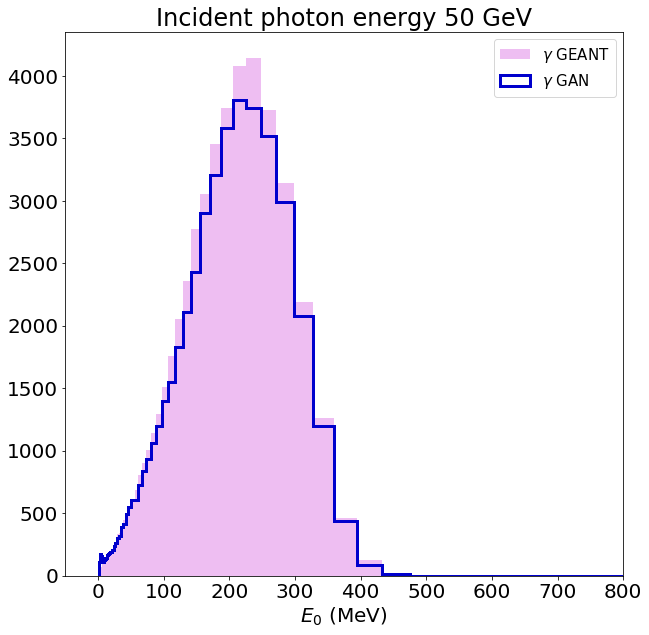

In [20]:
bins = np.logspace(-1, 3, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e0_orig_gamma, bins=bins, histtype='stepfilled', linewidth=3,
             alpha=0.3, color=colors[1],
             label=r'$\gamma$ GEANT')
_ = plt.hist(e0_gen_gamma, bins=bins, histtype='step', linewidth=3,
             alpha=1, color=colors[0],
             label=r'$\gamma$ GAN')

#plt.yscale('log')
#plt.xscale('log')
plt.xlim(xmax=800)
plt.legend(loc='upper right', ncol=1, fontsize=15)
plt.title("Incident photon energy 50 GeV")
plt.xlabel(r'$E_0$ (MeV)')
#plt.savefig('shower-shapes/e0-12x12-Epoh30.pdf')

Text(0.5, 0, '$E_1$ (MeV)')

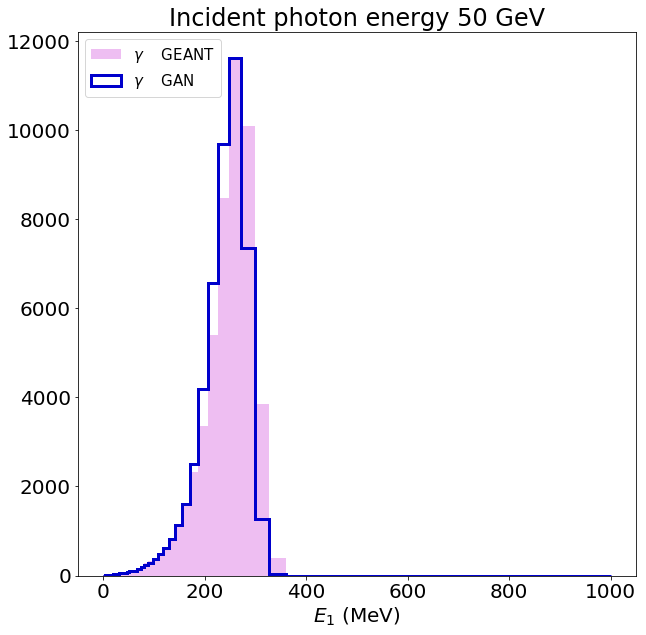

In [21]:
bins = np.logspace(-1, 3, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e1_orig_gamma, bins=bins, histtype='stepfilled', linewidth=3,
             alpha=0.3, color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(e1_gen_gamma, bins=bins, histtype='step', linewidth=3,
             alpha=1, color=colors[0],
             label=r'$\gamma$    GAN')

#plt.yscale('log')
#plt.xscale('log')
#plt.xlim(xmax=40)
plt.legend(loc='upper left', ncol=1, fontsize=15)
plt.title("Incident photon energy 50 GeV")
plt.xlabel(r'$E_1$ (MeV)')
#plt.savefig('shower-shapes/e1-12x12-Epoch30.pdf')

Text(0.5, 0, '$E_2$ (MeV)')

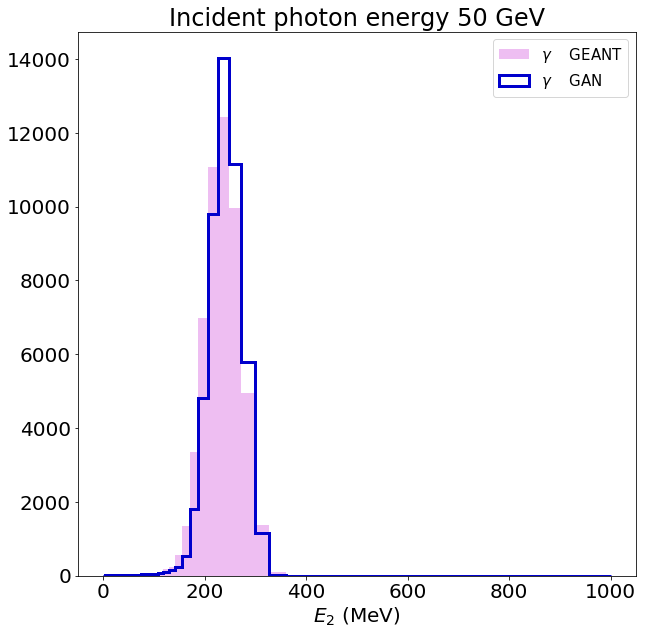

In [22]:
bins = np.logspace(-1, 3, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e2_orig_gamma, bins=bins, histtype='stepfilled', linewidth=3,
             alpha=0.3, color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(e2_gen_gamma, bins=bins, histtype='step', linewidth=3,
             alpha=1, color=colors[0],
             label=r'$\gamma$    GAN')

#plt.yscale('log')
#plt.xscale('log')
#plt.xlim(xmax=40)
plt.legend(loc='upper right', ncol=1, fontsize=15)
plt.title("Incident photon energy 50 GeV")
plt.xlabel(r'$E_2$ (MeV)')
#plt.savefig('shower-shapes/e2-12x12-Epoch30.pdf')

/software/anaconda3/5.2/lib/python3.6/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


Text(0.5, 0, '$E_3$ (MeV)')

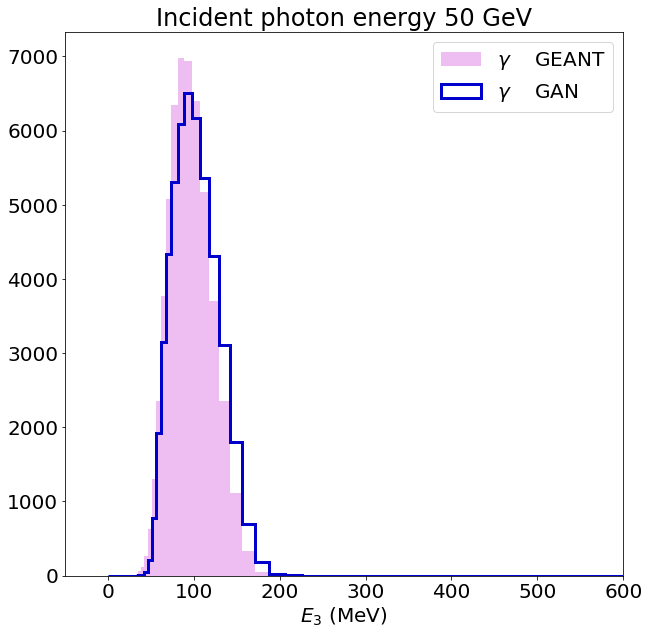

In [23]:
bins = np.logspace(-1, 3, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e3_orig_gamma, bins=bins, histtype='stepfilled', linewidth=3,
             alpha=0.3, color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(e3_gen_gamma, bins=bins, histtype='step', linewidth=3,
             alpha=1, color=colors[0],
             label=r'$\gamma$    GAN')

#plt.yscale('log')
#plt.xscale('log')
plt.xlim(xmax=600)
plt.legend(loc='upper right', ncol=1, fontsize=20)
plt.title("Incident photon energy 50 GeV")
plt.xlabel(r'$E_3$ (MeV)')
#plt.savefig('shower-shapes/e3-12x12-Epoch30.pdf')

Text(0.5, 0, '$E_4$ (MeV)')

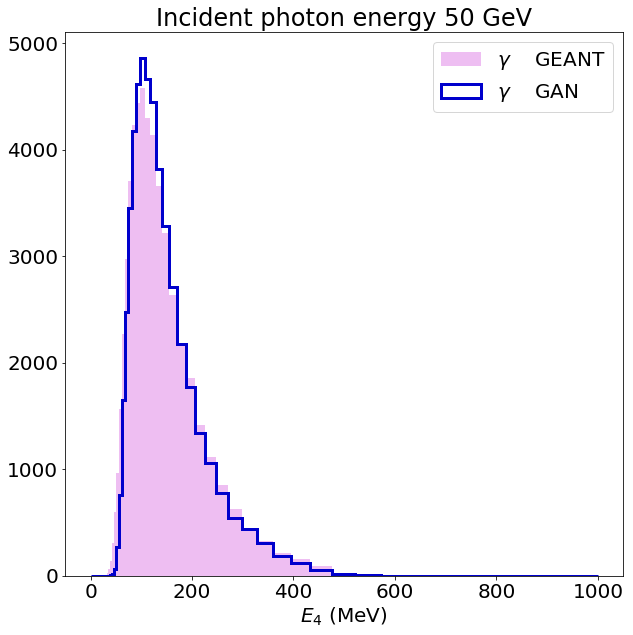

In [24]:
bins = np.logspace(-1, 3, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e4_orig_gamma, bins=bins, histtype='stepfilled', linewidth=3,
             alpha=0.3, color=colors[1],
             label=r'$\gamma$    GEANT')
_ = plt.hist(e4_gen_gamma, bins=bins, histtype='step', linewidth=3,
             alpha=1, color=colors[0],
             label=r'$\gamma$    GAN')

#plt.yscale('log')
#plt.xscale('log')
#plt.xlim(xmax=40)
plt.legend(loc='upper right', ncol=1, fontsize=20)
plt.title("Incident photon energy 50 GeV")
plt.xlabel(r'$E_4$ (MeV)')
#plt.savefig('shower-shapes/e4-12x12-Epoch30.pdf')